In [ ]:

# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 2️⃣ Load Dataset
df = pd.read_excel("Consumption Dataset.xlsx", sheet_name='Dataset')
df['Date Time Served'] = pd.to_datetime(df['Date Time Served'])
df['Date'] = df['Date Time Served'].dt.date
df['Consumed (ml)'].fillna(0, inplace=True)

C:\Users\aswin\AppData\Local\Temp\ipykernel_17020\3157351963.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Consumed (ml)'].fillna(0, inplace=True)


In [ ]:
# 3️⃣ Aggregate Daily Consumption
daily_consumption = df.groupby(['Date', 'Bar Name', 'Brand Name'])['Consumed (ml)'].sum().reset_index()
pivot_consumption = daily_consumption.pivot_table(
    index='Date',
    columns=['Bar Name', 'Brand Name'],
    values='Consumed (ml)',
    aggfunc='sum'
).fillna(0)

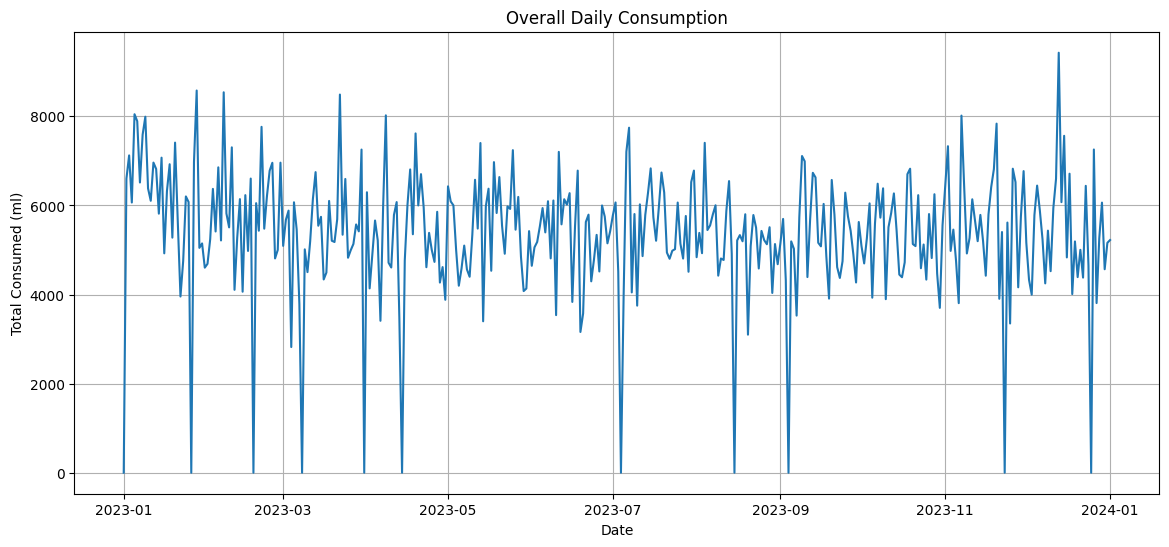

In [ ]:
# 4️⃣ Visualize Overall Daily Consumption
overall_daily = daily_consumption.groupby('Date')['Consumed (ml)'].sum()
plt.figure(figsize=(14,6))
overall_daily.plot()
plt.title('Overall Daily Consumption')
plt.ylabel('Total Consumed (ml)')
plt.xlabel('Date')
plt.grid()
plt.show()

In [ ]:
# 5️⃣ Forecasting Function
def forecast_and_recommend(series, forecast_horizon=7, safety_stock_factor=1.5):
    recent_mean = series[-30:].mean()
    forecast = recent_mean * forecast_horizon
    std_dev = series[-30:].std()
    safety_stock = safety_stock_factor * std_dev * np.sqrt(forecast_horizon)
    par_level = forecast + safety_stock
    return forecast, par_level

In [ ]:
# 6️⃣ Generate Forecast & Par Level
results = []
for bar, brand in pivot_consumption.columns:
    series = pivot_consumption[(bar, brand)].fillna(0)
    forecast, par_level = forecast_and_recommend(series)
    results.append({
        'Bar': bar,
        'Brand': brand,
        '7-day Forecast Consumption (ml)': forecast,
        'Recommended Par Level (ml)': par_level
    })

recommendation_df = pd.DataFrame(results).sort_values(by='Recommended Par Level (ml)', ascending=False)
display(recommendation_df.head(10))

,Bar,Brand,7-day Forecast Consumption (ml),Recommended Par Level (ml)
74,Taylor's Bar,Jim Beam,1002.880667,1963.581497
86,Thomas's Bar,Grey Goose,910.053667,1762.023459
27,Brown's Bar,Malibu,885.341333,1687.850281
54,Smith's Bar,Grey Goose,868.039667,1665.299285
10,Anderson's Bar,Jim Beam,795.256000,1593.477430
31,Brown's Bar,Yellow Tail,598.329667,1523.241682
1,Anderson's Bar,Bacardi,764.022000,1521.281019
77,Taylor's Bar,Smirnoff,790.141333,1495.179814
5,Anderson's Bar,Coors,705.285000,1459.194291
78,Taylor's Bar,Sutter Home,535.815000,1447.942364


In [ ]:

# 7️⃣ Simulate 30-day Demand to Check Stockouts
simulation_days = 30
sim_results = []
np.random.seed(42)

for index, row in recommendation_df.iterrows():
    bar = row['Bar']
    brand = row['Brand']
    par_level = row['Recommended Par Level (ml)']
    series = pivot_consumption[(bar, brand)].fillna(0)
    daily_mean = series[-30:].mean()
    daily_std = series[-30:].std()
    
    stock = par_level
    stockouts = 0
    
    for day in range(simulation_days):
        simulated_demand = np.random.normal(daily_mean, daily_std)
        simulated_demand = max(0, simulated_demand)
        if simulated_demand > stock:
            stockouts += 1
            stock = 0
        else:
            stock -= simulated_demand

    sim_results.append({
        'Bar': bar,
        'Brand': brand,
        'Simulated Stockouts (30 days)': stockouts,
        'Initial Par Level': par_level
    })

simulation_df = pd.DataFrame(sim_results)
final_report = pd.merge(recommendation_df, simulation_df, on=['Bar', 'Brand'])
final_report.sort_values(by='Simulated Stockouts (30 days)', ascending=False, inplace=True)
display(final_report.head(10)) 

,Bar,Brand,7-day Forecast Consumption (ml),Recommended Par Level (ml),Simulated Stockouts (30 days),Initial Par Level
47,Smith's Bar,Miller,360.789333,905.433826,20,905.433826
65,Johnson's Bar,Jim Beam,309.710333,792.814000,20,792.814000
37,Taylor's Bar,Jack Daniels,441.870333,1030.423544,20,1030.423544
20,Smith's Bar,Smirnoff,522.139333,1172.976681,18,1172.976681
43,Taylor's Bar,Budweiser,344.078000,955.904798,18,955.904798
34,Anderson's Bar,Heineken,442.078000,1060.698079,18,1060.698079
29,Thomas's Bar,Captain Morgan,481.481000,1112.026806,17,1112.026806
30,Taylor's Bar,Jameson,491.640333,1109.015591,17,1109.015591
91,Brown's Bar,Miller,49.011667,159.585504,17,159.585504
73,Thomas's Bar,Jim Beam,323.467667,679.697849,17,679.697849
